### Solar Power Forecasts

This notebook picks up where we left off, with a forecast dataset covering the Southeast including irradiance, temperature, and wind speed. We will turn that into power forecasts for many solar plants. 

In [8]:
from herbie import Herbie
from herbie import FastHerbie
import pandas as pd
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height, cm_pcp
from toolbox import EasyMap, pc, ccrs
import xarray as xr
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import pvlib

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

Let's load the netCDF file we crated in the last notebook, and then coarsen it to get the mean, min, and max of larger regions:

In [28]:
ds = xr.open_dataset('example_data/sample_hrrr_dataset.nc')

window_size = 10
ds_coarse = ds.coarsen(x=window_size, y=window_size, boundary='trim').mean() 
ds_coarse_max = ds.coarsen(x=window_size, y=window_size, boundary='trim').max()
ds_coarse_min = ds.coarsen(x=window_size, y=window_size, boundary='trim').min() 

Next, let's look at an aggregated forecast of many locations over a large area. We will load a list of plants.

This list is based on EIA Form 860 data [1]. Pulled list of solar plants (`3_3_Solar_Y2022_Early_Release.xlsx`), used `xlookup()` to merge latitude, longitude from full plant list (`2___Plant_Y2022_Early_Release.xlsx`), filtered on Balancing Area = SOCO, sorted by AC capacity. 

Made the following metadata assumptions:
 - `temperature_coefficient`: if crystalline, -0.35 %/deg C, if thin film, -0.25 %/deg C
 - `axis_tilt`, `axis_azimuth`, `rotation_angle`: if `tracking_type` is `single_axis`, 0, 180, 60, respectively
 - `backtracking`: if `single_axis` and crystalline, `True`, else, `False`
 - `ground_coverage_ratio`: `fixed` - 0.5; `single_axis` with thin film - 0.45; `single_axis` with crystalline - 0.35

 Merging, filtering, and filling in metadata was done in `pv_fleet_metadata.xlsx`, then saved as a .csv as `pv_fleet_metadata.csv`.

 [1] https://www.eia.gov/electricity/data/eia860/

In [10]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants
print('number of plants: ' + str(num_plants))
plants_df.head() # preview the DataFrame

number of plants: 51


,index,plant_name,plant_code,latitude,longitude,ac_capacity,dc_capacity,dc_loss_factor,temperature_coefficient,tracking,...,fixed_azimuth,axis_tilt,axis_azimuth,backtrack,max_rotation_angle,ground_coverage_ratio,Crystalline Silicon?,Thin-Film (CdTe)?,Operating_Month,Operating_Year
0,0,Cool Springs Solar (Hybrid),63721.0,30.747916,-84.680492,213.0,298.0,0.15,-0.35,Y,...,180,0.0,180.0,True,60.0,0.35,Y,NaN,12.0,2021.0
1,1,Twiggs Solar,61696.0,32.604997,-83.491239,204.0,261.0,0.15,-0.25,Y,...,0,0.0,180.0,False,60.0,0.45,NaN,Y,9.0,2020.0
2,2,Hickory Park Solar Hybrid,63522.0,31.269676,-84.176321,195.5,268.8,0.15,-0.35,Y,...,,0.0,180.0,True,60.0,0.35,Y,NaN,6.0,2022.0
3,3,Camilla Solar Energy Project,61785.0,31.269550,-84.228721,171.4,224.0,0.15,-0.35,Y,...,0,0.0,180.0,True,60.0,0.35,Y,NaN,2.0,2020.0
4,4,"SR DeSoto I, LLC",64841.0,31.886486,-84.021586,165.0,177.4,0.15,-0.25,Y,...,180,0.0,180.0,False,60.0,0.45,NaN,Y,12.0,2022.0


Here's a plot of the plants using `cartopy`, with the size of the marker corresponding to the AC capacity of each plant.

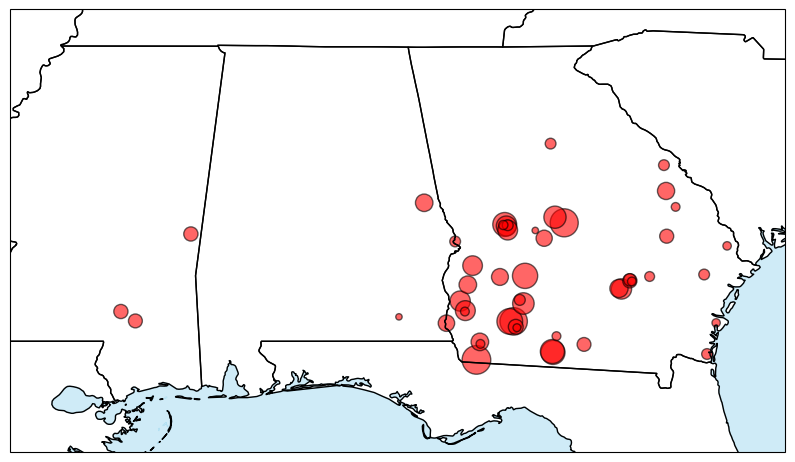

In [33]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)
ax.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
ax.add_feature(cfeature.STATES)

ax.set_extent([-91, -80.5, 29.5, 35.5],
              crs=crs.PlateCarree()) ## Important


plt.scatter(x=plants_df.longitude, y=plants_df.latitude,
            color="red",
            edgecolors='black',
            s=plants_df.ac_capacity*2,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important
# plt.savefig("site_map.png", dpi=150, bbox_inches='tight') # <-- uncomment this to save the image
plt.show()

### Irradiance data

Now let's get some irradiance data from the NREL NSRDB [1] using `pvlib` [2]. We will use this to as a proxy for measured data from a real fleet of plants. The NSRDB requires an API key from the NREL Developer Network [3]. We will use the `pvlib.iotools.get_psm3` function - details are here https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_psm3.html.

We will download the NSRDB data and metadata once and then store it in pickle files, so the next time we run it we can simply open the pickle file. If the list of plants changes after running the first time, you will need to delete the pickle files and run this again. 

Since HRRR hourly represents values on the hour (not an average acorss the hour), we want to make sure our NSRD-based calculations represent a similar time interval. In the 30-minute interval version of the NSRDB PSM3, every other value represents the average of 7 5-min interval measurements centered at the top of the hour:

```
Timestamps: 00 05 10 15 20 25 30 35 40 45 50 55 00 05 10 15 20 25
Interval 1:          --------------------
Interval 2:                            --------------------
```

(from [4])

We will pull the 30-min data and just save measurements with `Minute` of 0 (centered at the top of the hour).

*Note: For about 50 plants, this takes about 5-10 minutes to run. I'm not sure how much this is limited by my internet connection (~300 Mb/s) or NREL servers.* 

[1] https://nsrdb.nrel.gov/.

[2] William F. Holmgren, Clifford W. Hansen, and Mark A. Mikofski. “pvlib python: a python package for modeling solar energy systems.” Journal of Open Source Software, 3(29), 884, (2018). https://doi.org/10.21105/joss.00884

[3] https://developer.nrel.gov/signup/

[4] https://assessingsolar.github.io/unofficial-psm3-userguide/pages/data-aggregation.html

In [12]:
year = 2021
interval = 30

## API key credentials are stored in a separate text file
with open('nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
    email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
    nrel_api_key = f.readline().rstrip()

nsrdb_data_dict = {}
nsrdb_metadata_dict = {}

# data_filename = 'nsrdb_data_dict_pickle_' + str(year) + '_' + str(interval) + 'min_rev2.pickle'
# metadata_filename = 'nsrdb_metadata_dict_pickle_' + str(year) + '_' + str(interval) + 'min_rev2.pickle'

data_filename = 'nsrdb_data_dictionary_pickle_' + str(year) + '_60min_top_of_hour_from_30min.pickle'
metadata_filename = 'nsrdb_metadata_dictionary_pickle_' + str(year) + '_60min_top_of_hour_from_30min.pickle'

try: 
    # try to load dictionaries from existing pickle files
    pickle_in = open('example_data/'+data_filename, 'rb')
    nsrdb_data_dict = pickle.load(pickle_in)
    pickle_in = open('example_data/'+metadata_filename, 'rb')
    nsrdb_metadata_dict = pickle.load(pickle_in)
    print('loaded dictionaries from existing pickle files')
except: # if the pickle files don't exist, get NSRDB data, store in dictionaries, save as pickle files
    print('downloading new data from the NSRDB')
    for x in range(0,num_plants):
        lat = plants_df.iloc[x]['latitude'] 
        lon = plants_df.iloc[x]['longitude']
        nsrdb_data_dict[x], nsrdb_metadata_dict[x] = pvlib.iotools.get_psm3(latitude=lat,
                                                longitude=lon,
                                                api_key=nrel_api_key,
                                                email=email,
                                                names=year,
                                                interval=interval,
                                                leap_day=True,
                                                map_variables=True
                                                )

        # convert to UTC
        nsrdb_data_dict[x].index = nsrdb_data_dict[x].index.tz_convert('UTC')

        # only keep values that are centered on top of the hour 
        # to match HRRR hourly. See 
        # https://assessingsolar.github.io/unofficial-psm3-userguide/pages/data-aggregation.html
        nsrdb_data_dict[x] = nsrdb_data_dict[x].loc[nsrdb_data_dict[x]['Minute'] == 0]

        # adjust metadata to match
        nsrdb_metadata_dict[x]['Time Zone'] = 0

        # save dictionaries as pickle files
        pickle_out = open('example_data/'+data_filename, 'wb')
        pickle.dump(nsrdb_data_dict, pickle_out)
        pickle_out.close()

        pickle_out = open('example_data/'+metadata_filename, 'wb')
        pickle.dump(nsrdb_metadata_dict, pickle_out)
        pickle_out.close()
    print('done')

downloading new data from the NSRDB
done


### "Observed" power data

Let's use the NSRDB data to calculate ac power for each plant using the PVWatts model in `pvlib`. Remember, this is a proxy for measured ac power from real plants. 

We will also model clear sky power profiles using clear sky irradiance calculated with `pvlib`. See https://pvlib-python.readthedocs.io/en/stable/reference/clearsky.html. 

*Note: Clear sky irradiance is also available from the NSRDB - adding the option `attributes=[]` to `get_psm3()` above would retrieve those values. We are going to create out own clear sky profiles to more closely match how this might work in an operational environment with real plant data instead of NSRDB-based data.* 

Areas for improvement:
 - Add row-to-row self-shade for fixed tilt and single axis tracking *without backtracking* (i.e., thin-film truetracking). See:
   - https://github.com/pvlib/pvlib-python/discussions/1432#discussioncomment-7209858
   - https://github.com/pvlib/pvlib-python/pull/1725
   - https://github.com/pvlib/pvlib-python/issues/1689
   - https://github.com/pvlib/pvlib-python/issues/1690

We will create a function to run our power model that can be used later with forecasted weather. Inputs will be a _resource_data_ dataframe, a _plant_data_ dictionary (with a single plant's specifications pulled from _plants_df_), and then a boolean value for whether or not we want to calculate clear sky power.

In [13]:
def pvlib_power_model(resource_data, plant_data, calc_clear_sky = False):
    transposition_model = 'perez'
    eta_inv_nom = 0.98

    # solar position
    lat = plant_data['latitude'] 
    lon = plant_data['longitude']
    times = resource_data.index 
    loc= pvlib.location.Location(latitude=lat, longitude=lon, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # dni and airmass
    dni_extra = pvlib.irradiance.get_extra_radiation(resource_data.index)
    airmass = pvlib.atmosphere.get_relative_airmass(
        solar_position.apparent_zenith,
        model='gueymard2003'
    )

    if calc_clear_sky == True:
        # simlified solis with aod700=0.05 and precipitable_water=0.5 appears to give 
        # good results; goal is to set an upper-bound, not necessarily to be as accurate 
        # as possible
        clear_sky = loc.get_clearsky(times,
                                     model='simplified_solis',
                                     dni_extra=dni_extra,
                                     aod700 = 0.05,
                                     precipitable_water = 0.5)
    
    # surface tilt and azimuth
    if plant_data['tracking_type'] == 'single_axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                                 apparent_azimuth=solar_position.azimuth,
                                 axis_tilt=plant_data['axis_tilt'],
                                 axis_azimuth=plant_data['axis_azimuth'],
                                 backtrack=plant_data['backtrack'],
                                 gcr=plant_data['ground_coverage_ratio'],
                                 )
        orientation = pvlib.tracking.singleaxis(max_angle=plant_data['max_rotation_angle'],
                                                **singleaxis_kwargs)
        surface_tilt = orientation.surface_tilt.fillna(0)
        surface_azimuth = orientation.surface_azimuth.fillna(0)
    elif plant_data['tracking_type'] == 'fixed':
        surface_tilt = float(plant_data['fixed_tilt'])
        surface_azimuth = float(plant_data['fixed_azimuth'])

    # Transposed components of POA
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt, 
        surface_azimuth,
        solar_position.apparent_zenith, 
        solar_position.azimuth, 
        resource_data.dni, 
        resource_data.ghi, 
        resource_data.dhi, 
        airmass=airmass,
        albedo=resource_data.albedo, 
        dni_extra=dni_extra, 
        model=transposition_model
    )

    # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
    t_cell = pvlib.temperature.faiman(total_irradiance.poa_global,
                                      resource_data.temp_air,
                                      resource_data.wind_speed,
    )

    # PVWatts dc power
    pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance.poa_global,
                                    t_cell,
                                    plant_data['dc_capacity'],
                                    plant_data['temperature_coefficient']/100)
    pdc0 = plant_data['ac_capacity']/eta_inv_nom # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc_inv = pdc*(1-plant_data['dc_loss_factor']) # dc power into the inverter is modeled pdc after losses

    # PVWatts ac power
    power_ac = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

    if calc_clear_sky==True:
        # Transposed components of POA
        total_irradiance = pvlib.irradiance.get_total_irradiance(
            surface_tilt, 
            surface_azimuth,
            solar_position.apparent_zenith, 
            solar_position.azimuth, 
            clear_sky.dni, 
            clear_sky.ghi, 
            clear_sky.dhi, 
            airmass=airmass,
            albedo=resource_data.albedo, 
            dni_extra=dni_extra, 
            model=transposition_model
        )

        # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
        t_cell = pvlib.temperature.faiman(total_irradiance.poa_global,
                                        resource_data.temp_air,
                                        resource_data.wind_speed,
        )

        # PVWatts dc power
        pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance.poa_global,
                                        t_cell,
                                        plant_data['dc_capacity'],
                                        plant_data['temperature_coefficient']/100)
        pdc0 = plant_data['ac_capacity']/eta_inv_nom # inverter dc input is ac nameplate divided by nominal inverter efficiency
        pdc_inv = pdc*(1-plant_data['dc_loss_factor']) # dc power into the inverter is modeled pdc after losses

        # PVWatts ac power
        power_ac_clear_sky = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

    if calc_clear_sky == True:
        return power_ac, power_ac_clear_sky
    else:
        return power_ac

Here's a quick test of the function, manually specifying a single plant from the list:

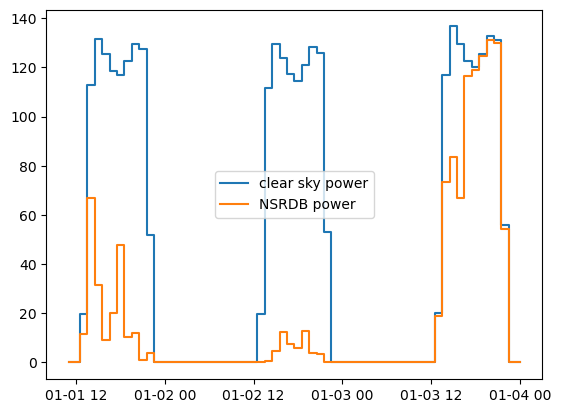

In [14]:
x = 3

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.iloc[x].dropna().to_dict()

# get resource data
resource_data = nsrdb_data_dict[x]

# calculate power and plot
power_ac, power_ac_clear_sky = pvlib_power_model(resource_data, plant_data, calc_clear_sky=True)
plt.plot(power_ac_clear_sky[6:68], drawstyle='steps-mid',)
plt.plot(power_ac[6:68], drawstyle='steps-mid',)
plt.legend(['clear sky power', 'NSRDB power'])
plt.show()

Now we can run that in a loop for all the plants, writing the output to a dictionary:

In [15]:
power_ac_nsrdb = {}
power_ac_cs = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()
    resource_data = nsrdb_data_dict[x]
    power_ac_nsrdb[x], power_ac_cs[x] = pvlib_power_model(
        resource_data,
        plant_data,
        calc_clear_sky=True,
    )

And sum the NSRDB-modeled power for each plant into a single series:

In [16]:
power_ac_nsrdb_all = pd.concat(power_ac_nsrdb, axis=1, sort=False).sum(axis=1)
power_ac_nsrdb_all = power_ac_nsrdb_all.to_frame(name='power_ac')
power_ac_nsrdb_all.index.names = ['time_center_labeled']
print('max power: ' + str(power_ac_nsrdb_all.max().values))
print('mean power: ' + str(power_ac_nsrdb_all.mean().values))
power_ac_nsrdb_all.head(12)

max power: [3694.99506046]
mean power: [1013.38275292]


,power_ac
time_center_labeled,
2021-01-01 05:00:00+00:00,0.000000
2021-01-01 06:00:00+00:00,0.000000
2021-01-01 07:00:00+00:00,0.000000
2021-01-01 08:00:00+00:00,0.000000
2021-01-01 09:00:00+00:00,0.000000
2021-01-01 10:00:00+00:00,0.000000
2021-01-01 11:00:00+00:00,0.000000
2021-01-01 12:00:00+00:00,0.000000
2021-01-01 13:00:00+00:00,187.827911


And sum the clear sky power:

In [17]:
power_ac_cs_all = pd.concat(power_ac_cs, axis=1, sort=False).sum(axis=1)
power_ac_cs_all = power_ac_cs_all.to_frame(name='power_ac')
power_ac_cs_all.index.names = ['time_center_labeled']
print('max power: ' + str(power_ac_cs_all.max().values))
print('mean power: ' + str(power_ac_cs_all.mean().values))

max power: [3703.5051469]
mean power: [1489.92586171]


### Forecasted power data


`herbie.accessors` includes a function, `nearest_ponts`, to get the nearest points from a Dataset [1]. You can pass it a tuple of a latitude, longitude pair, a list of pairs, or a DataFrame with `latitude` and `longitude` columns. It can also take in a point name, which we will use to assign EIA plant codes.

Then, let's add each plant's ac capacity (using the plant code as a reference). We will also drop unneeded columns and rename time columns to inlcude "utc".

[1] https://herbie.readthedocs.io/en/latest/api_reference/_autosummary/herbie.accessors.HerbieAccessor.html#herbie.accessors.HerbieAccessor.nearest_points

In [18]:
df_hrrr_plants = ds.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants = df_hrrr_plants.merge(plants_df[['plant_code','ac_capacity']],
                                       left_on='point', right_on='plant_code')
df_hrrr_plants.drop(columns={'plant_code', 'surface', 'heightAboveGround', 
                             'metpy_crs', 'gribfile_projection'}, inplace=True)
df_hrrr_plants.rename(columns={'time':'time_utc','valid_time':'valid_time_utc',
                               'point':'plant_code'},
                      inplace=True)
df_hrrr_plants.head()

,time_utc,step,plant_code,latitude,longitude,valid_time_utc,dswrf,t2m,u10,v10,t2m_c,wspd,y,x,point_latitude,point_longitude,ac_capacity
0,2021-06-18 06:00:00,1 days 03:00:00,63721.0,30.759312,275.325856,2021-06-19 09:00:00,0.000000,296.025909,-2.285221,1.563562,22.875916,2.768928,-777306.152557,1.232480e+06,30.747916,-84.680492,213.0
1,2021-06-18 06:00:00,1 days 04:00:00,63721.0,30.759312,275.325856,2021-06-19 10:00:00,0.000000,296.112000,-2.363213,2.086897,22.962006,3.152763,-777306.152557,1.232480e+06,30.747916,-84.680492,213.0
2,2021-06-18 06:00:00,1 days 05:00:00,63721.0,30.759312,275.325856,2021-06-19 11:00:00,14.400000,296.200958,-2.584122,1.495855,23.050964,2.985845,-777306.152557,1.232480e+06,30.747916,-84.680492,213.0
3,2021-06-18 06:00:00,1 days 06:00:00,63721.0,30.759312,275.325856,2021-06-19 12:00:00,124.500000,297.732269,-2.808473,2.153105,24.582275,3.538839,-777306.152557,1.232480e+06,30.747916,-84.680492,213.0
4,2021-06-18 06:00:00,1 days 07:00:00,63721.0,30.759312,275.325856,2021-06-19 13:00:00,90.900002,299.195374,-2.561988,3.466894,26.045380,4.310816,-777306.152557,1.232480e+06,30.747916,-84.680492,213.0


Now let's create a function to created a _resource_data_ dataframe from the HRRR data. It needs to add DNI and DHI that are calculated with a decomposition model. This is setup for options of Erbs and DIRINT models, but other models like Erbs-Driesse might also work well. 

In [19]:
def prep_hrrr_data(plant_data, forecast_df, decomposition_model = 'ers', albedo = 0.2):
    # Resource data
    plant_code = plant_data['plant_code']
    # arrange weather data for plant
    resource_data = forecast_df.loc[forecast_df['plant_code'] == plant_code,
                                ['valid_time_utc','dswrf', 't2m_c','wspd']].copy()
    resource_data = resource_data.set_index('valid_time_utc')
    resource_data.index = resource_data.index.tz_localize(tz='UTC')
    resource_data.rename(columns={'dswrf':'ghi', 't2m_c':'temp_air', 'wspd':'wind_speed'},
                    inplace=True)
    
    # solar position
    lat = plant_data['latitude'] 
    lon = plant_data['longitude']
    times = resource_data.index 
    loc= pvlib.location.Location(latitude=lat, longitude=lon, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # decomposition
    if decomposition_model=='erbs':
        out_erbs = pvlib.irradiance.erbs(
            resource_data.ghi,
            solar_position.zenith,
            resource_data.index,
        )
        resource_data['dni'] = out_erbs.dni
        resource_data['dhi'] = out_erbs.dhi
    elif decomposition_model=='dirint':
        dni_dirint = pvlib.irradiance.dirint(
            resource_data.ghi,
            solar_position.zenith,
            resource_data.index,
        )
        df_dirint = pvlib.irradiance.complete_irradiance(
            solar_zenith=solar_position.apparent_zenith,
            ghi=resource_data.ghi,
            dni=dni_dirint, dhi=None,
        )
        resource_data['dni'] = dni_dirint
        resource_data['dhi'] = df_dirint.dhi
    
    resource_data['albedo'] = albedo

    return resource_data

Then loop through each plant:

In [20]:
decomposition_model = 'erbs' # dirint or erbs
albedo = 0.2 # generic albedo value to use for the forecasts - something better could be added later

power_ac_hrrr = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()

    # resource data
    resource_data = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )

    # calculate power
    power_ac_hrrr[x] = pvlib_power_model(
        resource_data,
        plant_data,
        calc_clear_sky=False,
    )

And sum up the forecasted power for all sites:

In [21]:
power_ac_hrrr_all = pd.concat(power_ac_hrrr, axis=1, sort=False).sum(axis=1)
power_ac_hrrr_all = power_ac_hrrr_all.to_frame(name='power_ac')
power_ac_hrrr_all.index.names = ['time_center_labeled']
print('max power: ' + str(power_ac_hrrr_all.max().values))
print('mean power: ' + str(power_ac_hrrr_all.mean().values))

max power: [2502.43333075]
mean power: [997.63817796]


Now, let's plot "observed", forecasted, and clear sky power:

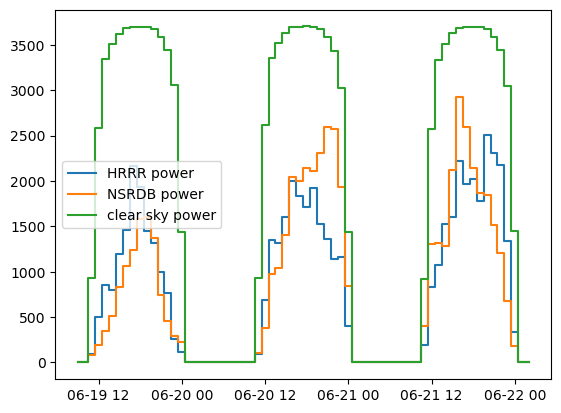

In [26]:
mask = ((power_ac_nsrdb_all.index >= power_ac_hrrr_all.index.min()) & 
        (power_ac_nsrdb_all.index <= power_ac_hrrr_all.index.max()))

plt.plot(power_ac_hrrr_all.index,power_ac_hrrr_all.power_ac,
         drawstyle='steps-mid', label='HRRR power')
plt.plot(power_ac_nsrdb_all.loc[mask].index, 
         power_ac_nsrdb_all.loc[mask].power_ac,
         drawstyle='steps-mid',
         label='NSRDB power')
plt.plot(power_ac_cs_all.loc[mask].index, 
         power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid',
         label='clear sky power')
plt.legend()
plt.show()

Then we can do the same thing, but with the coarsened mean, max, and min HRRR datasets to look at a more interesting forecast.

First, prep the HRRR datasets like we did previously:

In [29]:
# coarse mean
df_hrrr_plants_coarse = ds_coarse.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants_coarse = df_hrrr_plants_coarse.merge(
    plants_df[['plant_code','ac_capacity']],
    left_on='point', right_on='plant_code'
    )
df_hrrr_plants_coarse.drop(
    columns={'plant_code', 'surface', 'heightAboveGround', 
             'metpy_crs', 'gribfile_projection'},
             inplace=True
             )
df_hrrr_plants_coarse.rename(
    columns={'time':'time_utc','valid_time':'valid_time_utc',
             'point':'plant_code'},
             inplace=True
             )

# max
df_hrrr_plants_coarse_max = ds_coarse_max.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants_coarse_max = df_hrrr_plants_coarse_max.merge(
    plants_df[['plant_code','ac_capacity']],
    left_on='point', right_on='plant_code'
    )
df_hrrr_plants_coarse_max.drop(
    columns={'plant_code', 'surface', 'heightAboveGround', 
             'metpy_crs', 'gribfile_projection'},
             inplace=True
             )
df_hrrr_plants_coarse_max.rename(
    columns={'time':'time_utc','valid_time':'valid_time_utc',
             'point':'plant_code'},
             inplace=True
             )

# min
df_hrrr_plants_coarse_min = ds_coarse_min.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants_coarse_min = df_hrrr_plants_coarse_min.merge(
    plants_df[['plant_code','ac_capacity']],
    left_on='point', right_on='plant_code'
    )
df_hrrr_plants_coarse_min.drop(
    columns={'plant_code', 'surface', 'heightAboveGround', 
             'metpy_crs', 'gribfile_projection'},
             inplace=True
             )
df_hrrr_plants_coarse_min.rename(
    columns={'time':'time_utc','valid_time':'valid_time_utc',
             'point':'plant_code'},
             inplace=True
             )

Then loop through each plant:

In [30]:
decomposition_model = 'erbs' # dirint or erbs
albedo = 0.2 # generic albedo value to use for the forecasts - something better could be added later

p_ac_hrrr_coarse = {}
p_ac_hrrr_coarse_max = {}
p_ac_hrrr_coarse_min = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()

    # coarse mean
    resource_data_coarse = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants_coarse,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_coarse[x] = pvlib_power_model(
        resource_data_coarse,
        plant_data,
        calc_clear_sky=False,
    )

    # coarse max
    resource_data_coarse_max = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants_coarse_max,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_coarse_max[x] = pvlib_power_model(
        resource_data_coarse_max,
        plant_data,
        calc_clear_sky=False,
    )

    # coarse min
    resource_data_coarse_min = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants_coarse_min,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_coarse_min[x] = pvlib_power_model(
        resource_data_coarse_min,
        plant_data,
        calc_clear_sky=False,
    )

Then sum all plants for each forecast:

In [31]:
p_ac_hrrr_coarse_all = pd.concat(p_ac_hrrr_coarse, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_coarse_all = p_ac_hrrr_coarse_all.to_frame(name='power_ac')
p_ac_hrrr_coarse_all.index.names = ['time_center_labeled']

p_ac_hrrr_coarse_max_all = pd.concat(p_ac_hrrr_coarse_max, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_coarse_max_all = p_ac_hrrr_coarse_max_all.to_frame(name='power_ac')
p_ac_hrrr_coarse_max_all.index.names = ['time_center_labeled']

p_ac_hrrr_coarse_min_all = pd.concat(p_ac_hrrr_coarse_min, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_coarse_min_all = p_ac_hrrr_coarse_min_all.to_frame(name='power_ac')
p_ac_hrrr_coarse_min_all.index.names = ['time_center_labeled']

Now create a plot of everything together:

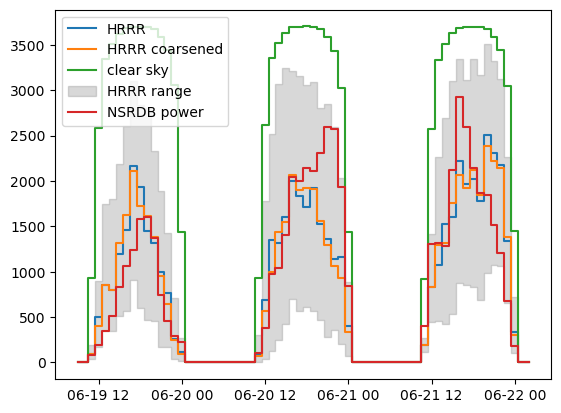

In [32]:
mask = (power_ac_nsrdb_all.index >= valid_start) & (power_ac_nsrdb_all.index <= valid_end)

plt.plot(power_ac_hrrr_all.index, power_ac_hrrr_all.power_ac, drawstyle='steps-mid',
         label='HRRR')
plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(power_ac_nsrdb_all.loc[mask].index, 
         power_ac_nsrdb_all.loc[mask].power_ac,
         drawstyle='steps-mid',
         label='NSRDB power')
plt.legend()
plt.show()

We can see that there are a number of interval where the "coarsened" version of the HRRR forecast is a little close to NSRDB-based actual power. And, for almost every interval, the actual power falls in the range of the "min" and "max" forecasts from the HRRR. 

That's the end of this notebook, please move on to the next one. 